# Annual Accumulation Graphs
## Written By Jared Rennie (@jjrennie)

In this notebook, you will learn how to make an annual accumulation graph, much like one you see <a href='https://twitter.com/jjrennie/status/1793318403526291827/' target="_blank">here</a>

We will utilize a stations data for it's period of record. Data originates from <a href='https://www.ncei.noaa.gov' target="_blank">NOAA NCEI</a>, who holds all of the worlds weather data. This code will show you how to access the data via an API, clean it up some, and plot a pretty graphic. 

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- requests (to access the api)
- pandas (to slice annd dice the data)
- matplotlib and seaborn (to plot!)
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import packages
%matplotlib inline
import json,requests,sys,calendar
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print("SUCCESS!")

SUCCESS!


If you made it this far, great!

### Insert Arguments
To access the data, we will be utilizing the <a href='https://www.rcc-acis.org/docs_webservices.html' target='blank'>ACIS API</a>, which is a quick and easy way to access our station data without having to download it yourself. First we need to know what we are plotting. The possible options are:

- prcp (Precipitation)
- snow (Snowfall)
- gdd (Growing Degree Days)
- cdd (Cooling Degree Days)
- hdd (Heating Degree Days)
- tmaxXXX (Number of Days Maximum Temperature >= Some User Defined Threshold)
- tminXXX (Number of Days Minimum Temperature >= Some User Defined Threshold)

Now we need to know what station to get data for. The ACIS API accepts all sorts of IDs, including:

- FAA (i.e. AVL)
- ghcn (i.e. USW00003812)
- ThreadEx (i.e. AVLthr)

If you're not sure, you can refer to the API documentation above. We also need to know which year we want to plot. And finally, need to give you credit for the image that is created at the end. 

 **Change the arguments below to your liking**

In [2]:
# Insert Arguments Here
stationID = 'NYC'
inElem = 'prcp'
plotYear=2024
author='Not Jared Rennie'

The rest of the code should work without making any changes to it, but if you're interested, keep on reading to see how the sausage is made.

This next block sets up some parameters, based upon what you decided 'inElem' would be.

In [3]:
# Set some parameters, based upon the element being used.
if inElem =='prcp':
    elementName='Precipitation'; acisName='pcpn'; acisPrec=2; acisDur='ytd'; acisSzn=[1,1]
    acisRed='sum'; colorMap='GnBu'; normalHex='#e6b800'; unit='"'; yBuff=10; outFmt="%.2f"
if inElem =='snow':
    elementName='Snowfall'; acisName='snow'; acisPrec=1; acisDur='std'; acisSzn=[10,1]
    acisRed='sum'; colorMap='Blues'; normalHex='#2070b4'; unit='"'; yBuff=10; outFmt="%.1f"
if inElem =='gdd':
    elementName='Growing Degree Days'; acisName='gdd'; acisPrec=0; acisDur='ytd'; acisSzn=[1,1]
    acisRed='sum'; colorMap='Greens'; normalHex='#228a44'; unit=' dd'; yBuff=500; outFmt="%i"
if inElem =='cdd':
    elementName='Cooling Degree Days'; acisName='cdd'; acisPrec=0; acisDur='ytd'; acisSzn=[1,1]
    acisRed='sum'; colorMap='OrRd'; normalHex='#d62f1e'; unit=' dd'; yBuff=500; outFmt="%i"
if inElem =='hdd':
    elementName='Heating Degree Days'; acisName='hdd'; acisPrec=0; acisDur='std'; acisSzn=[10,1]
    acisRed='sum'; colorMap='PuBu'; normalHex='#0570b0'; unit=' dd'; yBuff=500; outFmt="%i"
if inElem[0:4] == 'tmax':
    elementName='Days Max Temperature >= '+inElem[4:7].strip()+'°F'; acisName='maxt'; acisPrec=0; acisDur='ytd'; acisSzn=[1,1]
    acisRed='cnt_ge_%03i' % (int(inElem[4:7].strip())); colorMap='YlOrRd'; normalHex='#e6b800'; unit=' Days'; yBuff=10; outFmt="%i"
if inElem[0:4] == 'tmin':
    elementName='Days Min Temperature >= '+inElem[4:7].strip()+'°F'; acisName='mint'; acisPrec=0; acisDur='ytd'; acisSzn=[1,1]
    acisRed='cnt_ge_%03i' % (int(inElem[4:7].strip())); colorMap='YlOrRd'; normalHex='#e6b800'; unit=' Days'; yBuff=10; outFmt="%i"

print(elementName)

Precipitation


This next block of code will attempt to access the data we want from the ACIS API. Specifically, we are getting daily data for the stations period of record, as well as the 1991-2020 normal for each day of the year. The API is publicly available, but sometimes there are hiccups when getting the data. We tried to account for this with a try/exept in this code block and it will let you know if it fails after 3 seconds. If this happens, wait a minute, then try again.

In [4]:
# Build JSON to access ACIS API (from https://www.rcc-acis.org/docs_webservices.html)
acis_url = 'http://data.rcc-acis.org/StnData'
payload = {
"output": "json",
"params": {"elems":[
               {"name":acisName,"interval":"dly","duration":acisDur,"season_start":acisSzn,"reduce":acisRed,"prec":acisPrec},
               {"name":acisName,"interval":"dly","duration":acisDur,"season_start":acisSzn,"reduce":acisRed,"normal":"1","prec":acisPrec}
               ],
           "sid":stationID,"sdate":"por","edate":"por"
          } 
}

# Make Request
try:
    r = requests.post(acis_url, json=payload,timeout=3)
    acisData = r.json()
    print("SUCCESS!")
except Exception as e:
    sys.exit('\nSomething Went Wrong With Accessing API after 3 seconds, Try Again')

SUCCESS!


If it says "SUCCESS!" then congrats you got the data!

### Let's check the data!
How does it look? Well the data comes back as a JSON, which can be a little confusing to look at, so let's extract the information we need, and reorganize it a bit.

First, the JSON has a 'meta' key and a 'data' key. The 'meta' key gets us info like station name, latitude, longitude, etc. And 'data' is the actual data we requested. So let's get some station info, and convert the data into a pandas dataframe, which makes it easier to see. 

In [5]:
# Get Station Info
stationName=acisData['meta']['name'].title()
stationState=acisData['meta']['state']

# Convert data into Pandas DataFrame
acisPandas = pd.DataFrame(acisData['data'], columns=['Date',inElem+'_accum','normal_accum'])

print("\nSuccessfully Orgainzed Data for: ",stationName,',',stationState)
print(acisPandas)


Successfully Orgainzed Data for:  Ny City Central Park , NY
             Date prcp_accum normal_accum
0      1869-01-01       0.75         0.12
1      1869-01-02       0.78         0.24
2      1869-01-03       0.78         0.35
3      1869-01-04       0.96         0.48
4      1869-01-05       1.01         0.60
...           ...        ...          ...
56839  2024-08-15      33.98        30.61
56840  2024-08-16      33.98        30.75
56841  2024-08-17      34.02        30.90
56842  2024-08-18      36.31        31.04
56843  2024-08-19      36.56        31.18

[56844 rows x 3 columns]


You'll see there's a column for the date, and then 2 values. There's the recorded variable for a given day, and then the day's normal. Every decade, NCEI produces <a href='https://www.ncei.noaa.gov/products/land-based-station/us-climate-normals' target="_blank">30 year normals</a> which shows what values typically happen for a given day. The normals used at the time of writing utilze the 1991-2020 normals period. This is actually a good reference to weather versus climate. The normals are what you expect (climate) but the actual values are what you get (weather).

Sometimes people want to know what the station's period of record is, so let's get that info. 

In [6]:
stationStart=acisPandas.iloc[[0]]['Date'].values[0][0:4]
stationEnd=acisPandas.iloc[[-1]]['Date'].values[0][0:4]
print("Period of Record: ",stationStart,"-",stationEnd)

Period of Record:  1869 - 2024


### Cleaning the data
Now that we have the data we need, we need to do a few things before we can plot the data. This block of code will:
- Remove any missing data (defined as 'M' in the database)
- Account for trace data (defined as 'T' in the database)
- Convert columns to respective dates and numbers for plotting to work.
- Adds an additional column noting just the year

First, we will need to remove any missing data. ACIS defines missing data as 'M', so let's get rid of any of these instances. Also, we read in the data as a string, we will need to convert the date into a python-ic 'datetime' and temperature data into a number in order to plot the data appropriately.  

In [7]:
# Remove Missing Data, and if Trace, convert to something else
acisPandas = acisPandas[acisPandas[inElem+'_accum'] != 'M']
acisPandas = acisPandas[acisPandas['normal_accum'] != 'M']
if inElem =='prcp' or inElem =='snow':
    acisPandas.loc[acisPandas[inElem+'_accum'] == 'T', inElem+'_accum'] = '0.00'

# Make Sure Date is datetime and data is numeric (float)
acisPandas['Date'] = pd.to_datetime(acisPandas['Date'])
acisPandas['Year'] = acisPandas['Date'].dt.year
acisPandas[inElem+'_accum'] = pd.to_numeric(acisPandas[inElem+'_accum'])
acisPandas['normal_accum'] = pd.to_numeric(acisPandas['normal_accum'])

print(acisPandas)

            Date  prcp_accum  normal_accum  Year
0     1869-01-01        0.75          0.12  1869
1     1869-01-02        0.78          0.24  1869
2     1869-01-03        0.78          0.35  1869
3     1869-01-04        0.96          0.48  1869
4     1869-01-05        1.01          0.60  1869
...          ...         ...           ...   ...
56839 2024-08-15       33.98         30.61  2024
56840 2024-08-16       33.98         30.75  2024
56841 2024-08-17       34.02         30.90  2024
56842 2024-08-18       36.31         31.04  2024
56843 2024-08-19       36.56         31.18  2024

[56844 rows x 4 columns]


Not much changed when looking at the data again, but this is going to help us out with the next few steps.

For the next part, we have to account for what a "season" is. In most cases this is "January-December" but in the case of winter variables, such as snowfall and heating degree days, it's "October-September"

In [8]:
# Need to create a Season Column that is from Jan 1st to Dec 31st.
# If input is snowfall or hdd, it needs to be Oct 1st to Sep 30th.
if inElem =='snow' or inElem =='hdd':
    acisPandas['Season'] = acisPandas.apply(lambda row: f"{row['Year']-1}-{row['Year']}" if row['Date'].month <= 9 else f"{row['Year']}-{row['Year']+1}", axis=1)
else:
    acisPandas['Season'] = acisPandas['Year']
acisPandas['DayOfSeason']=acisPandas.groupby('Season').cumcount() + 1
print(acisPandas)

            Date  prcp_accum  normal_accum  Year  Season  DayOfSeason
0     1869-01-01        0.75          0.12  1869    1869            1
1     1869-01-02        0.78          0.24  1869    1869            2
2     1869-01-03        0.78          0.35  1869    1869            3
3     1869-01-04        0.96          0.48  1869    1869            4
4     1869-01-05        1.01          0.60  1869    1869            5
...          ...         ...           ...   ...     ...          ...
56839 2024-08-15       33.98         30.61  2024    2024          228
56840 2024-08-16       33.98         30.75  2024    2024          229
56841 2024-08-17       34.02         30.90  2024    2024          230
56842 2024-08-18       36.31         31.04  2024    2024          231
56843 2024-08-19       36.56         31.18  2024    2024          232

[56844 rows x 6 columns]


Now we have seasons established, we only want to plot a full season's worth of data, unless it's the current year

In [9]:
# Remove Seasons that aren't complete, but keep last season (usually current season). 
dayThresh=350
days_per_year = acisPandas.groupby('Season')['Date'].nunique()
complete_years = days_per_year[(days_per_year >= dayThresh) | (days_per_year.index == acisPandas['Season'].max())].index
acisPandas=acisPandas[acisPandas['Season'].isin(complete_years)]
lastDate=acisPandas.iloc[-1]['Date']

Finally let's get some stats, including Max and Min Year

In [10]:
# Find the accumulation value at the end of each season, sort, and get Max/Min
eoyVals=acisPandas.groupby('Season').apply(lambda group: group.loc[group['Date'].idxmax()])
eoyVals=eoyVals[eoyVals['DayOfSeason'] >= dayThresh]
sorted_years = eoyVals.sort_values(by=inElem+'_accum')['Season']
minYear=sorted_years.iloc[0]
minVal=outFmt % (eoyVals[eoyVals['Season']==minYear][inElem+'_accum'].values[0])
maxYear=sorted_years.iloc[-1]
maxVal=outFmt % (eoyVals[eoyVals['Season']==maxYear][inElem+'_accum'].values[0])

print('MAX year is ',maxYear,': ',maxVal)
print('MIN year is ',minYear,': ',minVal)

MAX year is  1983 :  80.56
MIN year is  1965 :  26.09


Now for the fun part...

### Plotting the data!

This last block of code will plot the data. Feel free to play around and adjust colors and settings to your liking. One additional thing this block does is create 2 different y-axis, one for Fahrenheit and one for Celsius.

PLOTTING


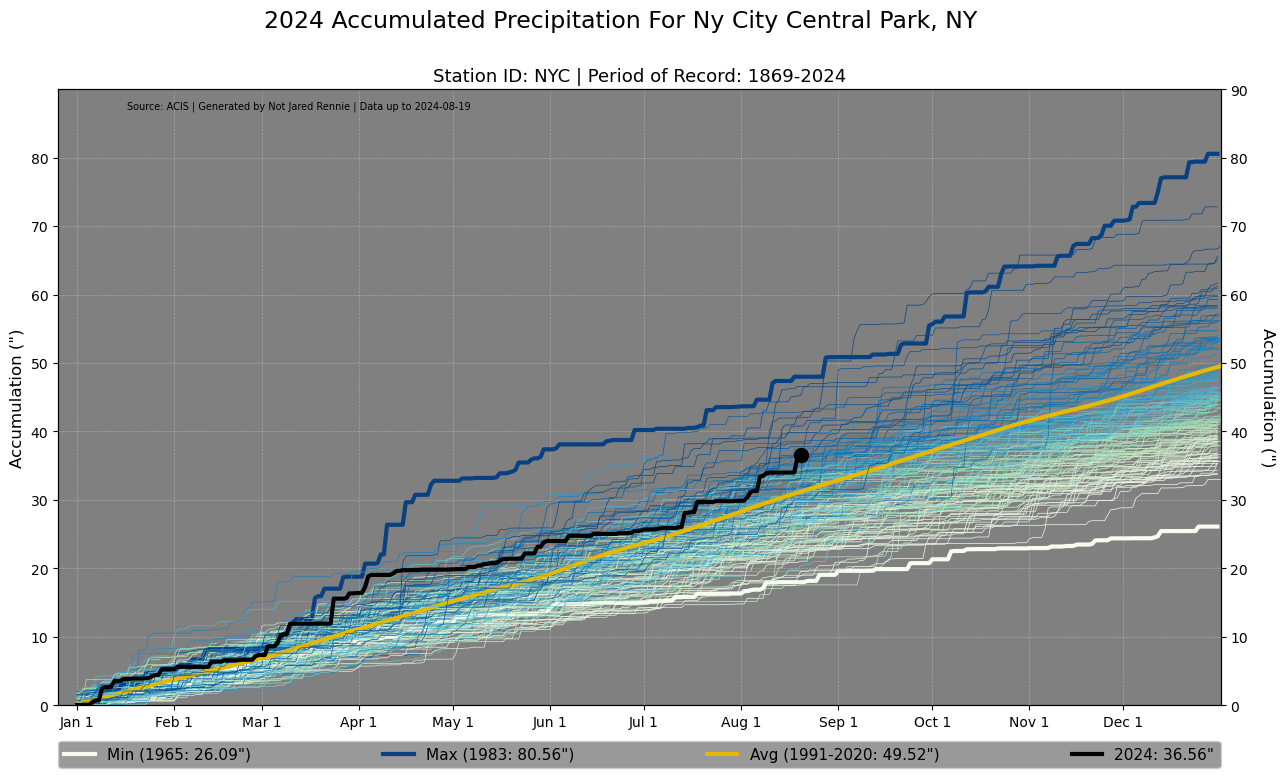

In [11]:
#################################################
# PLOT
print("PLOTTING")
dpi=100

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 8), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_facecolor('#808080')

# Need to account for years in season, as well as normal year
if inElem =='snow' or inElem =='hdd':
    plotYear=str(int(plotYear))+'-'+str(int(plotYear+1))
    normalYear='2020-2021'
else:
	normalYear='2020'

# Sort Again Before Plotting. User can choose to sort by end of season value, or by year. Default is by value
eoyVals=acisPandas.groupby('Season').apply(lambda group: group.loc[group['Date'].idxmax()])
#sorted_years = eoyVals.sort_values(by='Year')['Season']
sorted_years = eoyVals.sort_values(by=inElem+'_accum')['Season']

# Plot Data For Each Year
for year, group in acisPandas.groupby('Season'):
    color = sns.color_palette(colorMap, n_colors=len(sorted_years))[sorted_years.tolist().index(year)]
    plt.plot(group['DayOfSeason'], group[inElem+'_accum'],linewidth=0.5, color=color)
    
    # Plot for Max/Min Year
    if str(year) == str(maxYear):
        plt.plot(group['DayOfSeason'], group[inElem+'_accum'],linewidth=3, color=color, label='Max ('+str(maxYear)+': '+str(maxVal)+str(unit)+')') 
    if str(year) == str(minYear):
        plt.plot(group['DayOfSeason'], group[inElem+'_accum'],linewidth=3, color=color, label='Min ('+str(minYear)+': '+str(minVal)+str(unit)+')') 

    # Plot Normal
    normals_start=1991; normals_end=2020
    if str(year) == str(normalYear):
        plt.plot(group['DayOfSeason'], group['normal_accum'],linewidth=3, color=normalHex, label='Avg ('+str(normals_start)+'-'+str(normals_end)+': '+str(group['normal_accum'].iloc[-1])+str(unit)+')')

    # Plot Year Used as Input
    if str(year) == str(plotYear):
        plt.plot(group['DayOfSeason'], group[inElem+'_accum'], color='black', markeredgecolor='white', linewidth=3, label=str(plotYear)+': '+str(group[inElem+'_accum'].iloc[-1])+str(unit)+'')
        plt.plot(group['DayOfSeason'].iloc[-1],group[inElem+'_accum'].iloc[-1], marker='o', color='black', markersize=10)

# Plot Legend
plt.legend(bbox_to_anchor=(0., -.102, 1., -1.02), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=11, facecolor='#808080')

# Set X/Y limits
plt.xlim(-5, 366) 
ymin=int(acisPandas[inElem+'_accum'].min())
ymax=int(acisPandas[inElem+'_accum'].max())
ymax=int(round(float(ymax + yBuff)))
plt.ylim(ymin,ymax)

# Plot X-Axis Labels/Ticks
if inElem =='snow' or inElem =='hdd':
	month_pos=[1,32,62,93,124,152,183,213,244,274,305,336]
	month_names=["Oct 1","Nov 1","Dec 1","Jan 1","Feb 1","Mar 1","Apr 1","May 1","Jun 1","Jul 1","Aug 1","Sep 1"]
else:
	month_pos=[1,32,60,91,121,152,182,213,244,274,305,335]
	month_names=["Jan 1","Feb 1","Mar 1","Apr 1","May 1","Jun 1","Jul 1","Aug 1","Sep 1","Oct 1","Nov 1","Dec 1"]
plt.xticks(month_pos, month_names, fontsize=10, color='black')

# Plot Y-Axis Labels/Ticks (Left Side)
plt.yticks(range(ymin, ymax, yBuff), [r'{}'.format(x) for x in range(ymin, ymax, yBuff)], fontsize=10, color='black')
plt.ylabel('Accumulation ('+str(unit.strip())+')', fontsize=12, color='black')

# Plot Y-Axis Labels/Ticks (Right Side)
ax2 = ax1.twinx()
y1, y2 = ax1.get_ylim()
ax2.set_ylim(int(y1), int(y2))
ax2.figure.canvas.draw()
ax1.callbacks.connect("ylim_changed", ax2)
ax2.set_ylabel('Accumulation ('+str(unit.strip())+')', fontsize=12, rotation=270, labelpad=20,color='black')

# Plot Title/Subtitle/Annotations
plt.suptitle(str(plotYear)+' Accumulated '+elementName+' For '+stationName+', '+stationState, fontsize=17,color='black')
plt.title('Station ID: '+stationID+' | Period of Record: '+str(stationStart)+'-'+str(stationEnd), fontsize=13,color='black')
plt.annotate('Source: ACIS | Generated by '+author+' | Data up to '+lastDate.strftime('%Y-%m-%d'),xy=(0.355, 0.965), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom')

# Show results
plt.show()

Isn't it beautiful? Congrats! You made an annual accumulation graphic! Feel free to post on social media for the world to see!

**Congrats on completing this notebook! Now go forth and make better plots!**